# JaSP: un simple pathfinder aplicado a laberintos

<p style="text-align:center;">
<b>Inteligencia Artificial<br>
Facultad de Ingeniería Eléctrica</b>
</p>

**INTEGRANTES DEL EQUIPO**
- GUSTAVO ALONSO ANAYA MORENO (2001284f@umich.mx)
- AARON URIEL GUZMAN CARDOSO (2100554h@umich.mx)
- PERLA PAOLA PANTALEON BEDOLLA (2001285b@umich.mx)

# Introducción

## El problema
Buscamos encontrar una ruta válida desde $\mathbf{a}$ hasta $\mathbf{b}$, tomando en cuenta solo caminos posibles para el agente de IA. Este tendrá un espacio representado por una matriz binaria $\mathbf{M}$ de $m$ por $n$, tal que el valor de cada celda corresponde a la expresión booleana "**No es posible atravesar la celda sin encontrar un obstáculo**".  
### Estado
#### Almacenamiento
Para la resolución de este problema tenemos los siguientes constructos para el almacenamiento del **estado** del problema:
- Posición del agente en la iteración $i$: 
$$
\mathbf{p}_i =
\begin{bmatrix}
x_i \\
y_i \\
\end{bmatrix}
$$
- El vector de posición inicial $\mathbf{a}$.
- El vector de posición meta $\mathbf{b}$ del agente.

#### Manipulación
Como deseamos manipular $\mathbf{p}$ durante iteraciones progresivas hemos definido al operador sucesor como:  
$$S_i = \text{Succ}(\mathbf{p}_i) \subseteq D$$
Tal que todo elemento de $S_i$ cumpla con "**ser una celda dentro de los confines de la matriz, que esta sea un camino libre, y que este pertenezca a $D$**". Aquí $D$ es el conjunto de todas las traslaciones que **pueden** ser válidas para el vector $\mathbf{p}$, en este caso se trata de un vecindario von Neumann:  
$$D = \{\mathbf{d}_{\text{up}}, \mathbf{d}_{\text{down}}, \mathbf{d}_{\text{left}}, \mathbf{d}_{\text{right}} \}$$

#### Condición de meta
La condición de meta será simplemente que $\mathbf{p}_i = \mathbf{b}$

#### Heurística
La heurística considerada para el método **A\*** será la distancia Manhattan, ya que esta representa adecuadamente los movimientos posibles para el agente (arriba, abajo, izquierda y derecha pero no diagonales). 
$$ h(x_i,y_i) = | b_1 - x_i| + |b_2 - y_i|$$
Siendo que:
- $b_1$ y $b_2$ son las posiciones meta.
- $x_i$ y $y_i$ son las posiciones de la iteración $i$.

##### Admisibilidad de la Herurística
Nunca sobreestima el costo real de llegar a la meta. En un laberinto de cuadrícula, el camino más corto siempre será igual o mayor que la suma de las distancias horizontales y verticales.


## Propuesta de solución
Dado el problema se realizará su planteamiento y solución en Python con ayuda de la biblioteca incluida en este mismo repositorio [SimpleSearch](https://github.com/kyriox/baile/blob/master/src/SimpleSearch.py), para realizar así búsqueda no informada (BFS, DFS) y búsqueda informada (A\*).  
La resolución inicialmente solo se restringirá a laberintos arbitrarios hechos con el algoritmo de Kruskal, en donde solo habrá un único camino solución. La creación de entornos más complicados queda pendiente de desarrollar para una futura entrega.

### Algoritmo de Kruskal

In [180]:
from itertools import groupby
from typing import Any, List, Tuple, Union, Literal
import random
from numpy import ndarray

def kruskal(
        edges: List[Tuple[Union[int, float], Any, Any]],
        tie_break: Literal["random"] = "random",
        random_seed: int = 42
    ) -> List[Tuple[Union[int, float], Any, Any]]:
    edge_weight_groups = [
        (weight, list(group))
        for weight, group in groupby(
            sorted(edges, key=lambda x: x[0]),
            key=lambda x: x[0]
        )
    ]
    if tie_break == "random":
        random.seed(random_seed)
        for _, group in edge_weight_groups:
            random.shuffle(group)
    parent = {}
    rank = {}

    def find(node):
        if parent[node] != node:
            parent[node] = find(parent[node])
        return parent[node]

    def union(node1, node2):
        root1 = find(node1)
        root2 = find(node2)
        if root1 != root2:
            if rank[root1] > rank[root2]:
                parent[root2] = root1
            elif rank[root1] < rank[root2]:
                parent[root1] = root2
            else:
                parent[root2] = root1
                rank[root1] += 1
            return True  # Unión realizada
        return False  # Ya estaban en el mismo conjunto

    nodes = set()
    for weight, u, v in edges:
        nodes.update([u, v])
    
    for node in nodes:
        parent[node] = node
        rank[node] = 0

    mst = []
    for weight, edge_group in edge_weight_groups:
        for (_, origin_node, dest_node) in edge_group:
            if union(origin_node, dest_node):
                mst.append((weight, origin_node, dest_node))
                
                # Terminamos si ya tenemos el MST completo
                if len(mst) == len(nodes) - 1:
                    return mst

    return mst

### Creador de laberintos de prueba

In [181]:
from itertools import groupby
from typing import Any, List, Tuple, Union, Literal
import random
import numpy as np
from numpy.typing import NDArray

def maze_builder(
        m: int, n: int, random_seed: int = 42,
        extra_paths_ratio: float = 0.1
    ) -> Tuple[
        NDArray[np.int_], Tuple[int, int], Tuple[int, int]
    ]:
    random.seed(random_seed)
    
    # Dimensionalidad impar para hacer bien el laberinto
    if m % 2 == 0:
        m += 1
    if n % 2 == 0:
        n += 1
    
    # Crear laberinto lleno de paredes
    maze = np.ones((m, n), dtype=np.int_)
    
    # Crear tabla de nodos con posiciones impares
    node_table = {}
    nodes = []
    for i in range(1, m, 2):
        for j in range(1, n, 2):
            node_table[(i, j)] = (i, j)
            nodes.append((i, j))
            maze[i, j] = 0
    
    all_edges = []
    for i in range(1, m, 2):
        for j in range(1, n, 2):
            current_node = node_table[(i, j)]
            
            # Conexión hacia abajo: (i,j) → (i+2,j)
            if i + 2 < m:
                next_node = node_table[(i + 2, j)]
                weight = random.random()
                all_edges.append((weight, current_node, next_node))
            
            # Conexión hacia la derecha: (i,j) → (i,j+2)
            if j + 2 < n:
                next_node = node_table[(i, j + 2)]
                weight = random.random()
                all_edges.append((weight, current_node, next_node))
    
    mst = kruskal(all_edges.copy())
    used_edges = set()
    
    # Cavar caminos del MST
    for _, (x1, y1), (x2, y2) in mst:
        wall_x, wall_y = (x1 + x2) // 2, (y1 + y2) // 2
        maze[wall_x, wall_y] = 0
        # Marcamos arista como usada
        used_edges.add(frozenset([(x1, y1), (x2, y2)]))
    
    # Calculamos aristas no usados aún
    remaining_edges = [
        edge for edge in all_edges 
        if frozenset([edge[1], edge[2]]) not in used_edges
    ]
    
    # Calcular cuántas aristas adicionales agregar
    num_extra_edges = int(len(remaining_edges) * extra_paths_ratio)
    
    # Seleccionar aristas adicionales aleatoriamente
    if num_extra_edges > 0:
        random.shuffle(remaining_edges)
        extra_edges = remaining_edges[:num_extra_edges]
        
        # Cavar caminos adicionales
        for _, (x1, y1), (x2, y2) in extra_edges:
            wall_x, wall_y = (x1 + x2) // 2, (y1 + y2) // 2
            maze[wall_x, wall_y] = 0
    
    # Seleccionar inicio y fin en posiciones válidas
    free_cells = [(i, j) for i in range(m) for j in range(n) if maze[i, j] == 0]
    
    if len(free_cells) >= 2:
        start = free_cells[0]
        end = free_cells[-1]
    else:
        start = (1, 1) if maze[1, 1] == 0 else (0, 0)
        end = (m-2, n-2) if maze[m-2, n-2] == 0 else (m-1, n-1)
    
    return maze, start, end


In [182]:
def draw_maze(maze, start=None, end=None, paths_dict={}, separate_plots=False, figsize=(15, 5)):
    import matplotlib.pyplot as plt
    import numpy as np

    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    if separate_plots and paths_dict:
        # Dibujar cada camino en subplot separado
        fig, axes = plt.subplots(1, len(paths_dict), figsize=figsize)
        if len(paths_dict) == 1:
            axes = [axes]  # Manejar caso de un solo subplot
            
        for ax, ((name, path), color) in zip(axes, zip(paths_dict.items(), colors)):
            grid = np.array(maze)
            ax.imshow(grid, cmap="binary")
            
            if start is not None: 
                ax.plot(start[1], start[0], marker='o', color='lime', markersize=10, 
                       markeredgecolor='black', markeredgewidth=2, label='Inicio')
            if end is not None:
                ax.plot(end[1], end[0], marker='X', color='red', markersize=12, 
                       markeredgecolor='black', markeredgewidth=2, label='Fin')
            
            # Dibujar el camino
            if path:
                xs = [p[0][1] for p in path]
                ys = [p[0][0] for p in path]
                ax.plot(xs, ys, color=color, linewidth=2, alpha=0.8)
            
            ax.set_title(name)
            ax.axis("off")
        
        plt.tight_layout()
        plt.show()
    
    else:
        # Dibujar todos los caminos en una sola gráfica
        grid = np.array(maze)
        plt.figure(figsize=(8, 8))
        plt.imshow(grid, cmap="binary")
        
        if start is not None: 
            plt.plot(start[1], start[0], marker='o', color='lime', markersize=12, 
                    markeredgecolor='black', markeredgewidth=2, label='Inicio', zorder=10)
        if end is not None:
            plt.plot(end[1], end[0], marker='X', color='red', markersize=14, 
                    markeredgecolor='black', markeredgewidth=2, label='Fin', zorder=10)
        
        # Calculo de offsets para caminos distinguibles
        num_paths = len(paths_dict)
        if num_paths > 1:
            # Generar offsets en círculo para mejor distribución
            import math
            offsets = [
                (0.2 * math.cos(2 * math.pi * i / num_paths), 
                 0.2 * math.sin(2 * math.pi * i / num_paths))
                for i in range(num_paths)
            ]
        else:
            offsets = [(0, 0)]
        
        # Dibujar cada camino con su color y offset
        for (name, path), color, offset in zip(paths_dict.items(), colors, offsets):
            if path:
                xs = [p[0][1] + offset[0] for p in path]
                ys = [p[0][0] + offset[1] for p in path]
                plt.plot(xs, ys, color=color, linewidth=2, label=name, alpha=0.8)
        
        # Crear leyenda combinada
        if paths_dict or start is not None or end is not None:
            plt.legend(loc='upper right')
        
        plt.title("Laberinto" + (" con caminos" if paths_dict else ""))
        plt.axis("off")
        plt.show()

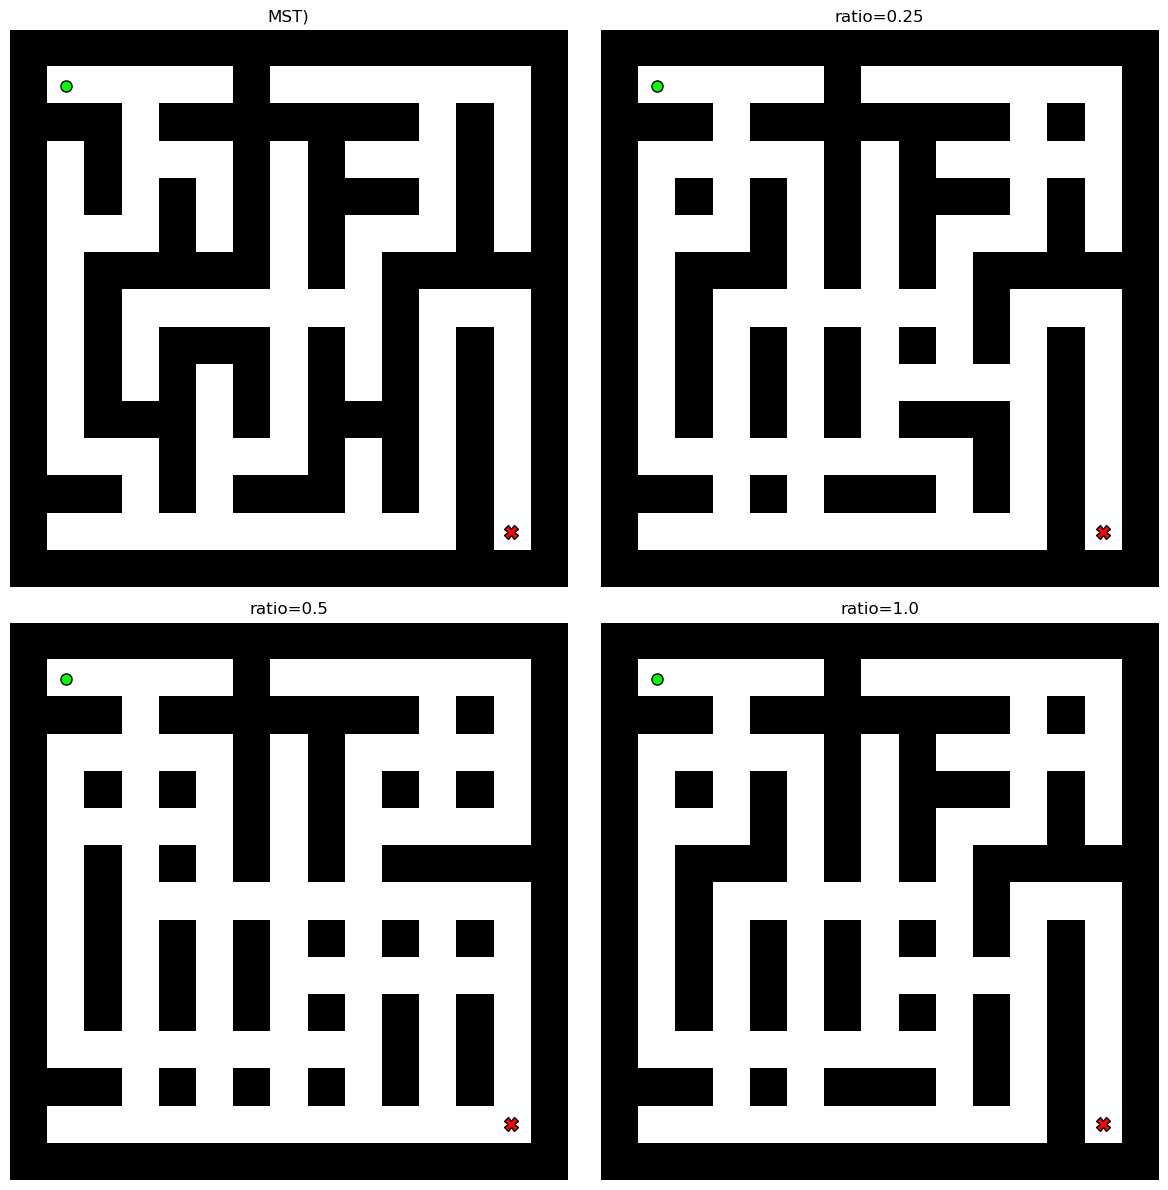

MST): 97 celdas libres de 225 (43.1% densidad)
ratio=0.25: 106 celdas libres de 225 (47.1% densidad)
ratio=0.5: 115 celdas libres de 225 (51.1% densidad)
ratio=1.0: 107 celdas libres de 225 (47.6% densidad)


In [183]:
def maze_comparison(m: int, n: int, random_seed: int = 42):
    """
    Crea variantes del mismo laberinto con diferentes números de caminos.
    """
    variants = {
        "MST)": maze_builder(m, n, random_seed, extra_paths_ratio=0.0),
        "ratio=0.25": maze_builder(m, n, random_seed, extra_paths_ratio=0.25),
        "ratio=0.5": maze_builder(m, n, random_seed, extra_paths_ratio=0.5),
        "ratio=1.0": maze_builder(m, n, random_seed, extra_paths_ratio=0.3)
    }
    return variants

import matplotlib.pyplot as plt

# Crear variantes del laberinto
variants = maze_comparison(15, 15, random_seed=42)

# Mostrar las variantes en subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, (name, (maze_var, start_var, end_var)) in enumerate(variants.items()):
    ax = axes[idx]
    ax.imshow(np.array(maze_var), cmap="binary")
    
    # Dibujar puntos de inicio y final
    ax.plot(start_var[1], start_var[0], marker='o', color='lime', markersize=8, 
           markeredgecolor='black', markeredgewidth=1)
    ax.plot(end_var[1], end_var[0], marker='X', color='red', markersize=10, 
           markeredgecolor='black', markeredgewidth=1)
    
    ax.set_title(f"{name}")
    ax.axis("off")

plt.tight_layout()
plt.show()

# Información sobre la complejidad
for name, (maze_var, start_var, end_var) in variants.items():
    free_cells = np.sum(maze_var == 0)
    total_cells = maze_var.size
    density = free_cells / total_cells
    print(f"{name}: {free_cells} celdas libres de {total_cells} ({density:.1%} densidad)")

## Desarrollo

### Creación del entorno y metas

In [184]:

from src.SimpleSearch import node, BlindSearch
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd

Inicio: (1, 1), Fin: (21, 21)


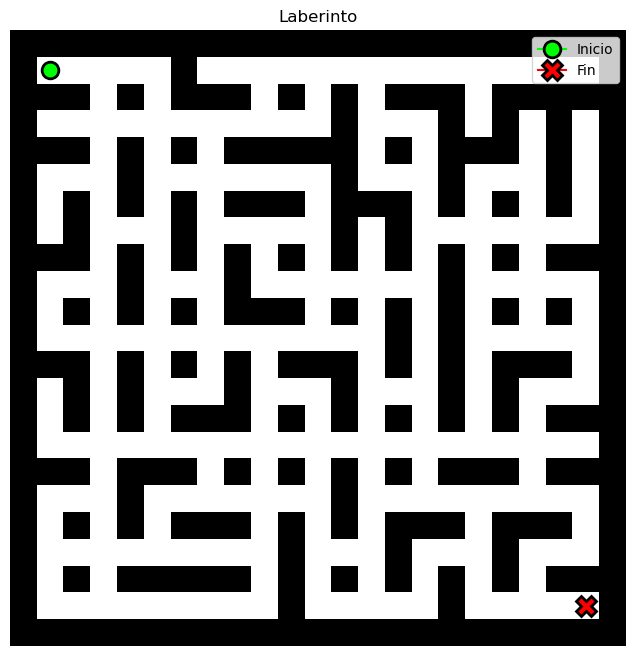

In [185]:
maze = [
    [0,0,1,0,0,0,1,0,0,0],
    [1,0,1,0,1,0,1,0,1,0],
    [0,0,0,0,1,0,0,0,1,0],
    [0,1,1,1,1,1,1,0,1,0],
    [0,0,0,0,0,0,1,0,1,0],
    [1,1,1,1,1,0,1,0,1,0],
    [0,0,0,0,1,0,0,0,1,0],
    [0,1,1,0,1,0,1,1,1,0],
    [0,0,0,0,0,0,0,0,0,0],
    [1,1,1,1,1,1,1,1,1,0]
]

start_state = (0,0)   
goal_state  = (9,9)   

maze, start_state, goal_state = maze_builder(23, 23, random_seed=42, extra_paths_ratio=0.4)
print(f"Inicio: {start_state}, Fin: {goal_state}")
draw_maze(maze, start_state, goal_state)

### Funciones que alteran el estado del problema

In [186]:
MOVES = {
    "up": (-1,0),
    "down": (1,0),
    "left": (0,-1),
    "right": (0,1)
}

def successor(n):
    x, y = n.state
    valid = lambda nx, ny: 0 <= nx < len(maze) and 0 <= ny < len(maze[0]) and maze[nx][ny] == 0
    successors = [
        node(state=(x+dx, y+dy), parent=n, depth=n.depth+1, op=action)
        for action, (dx, dy) in MOVES.items()
        if valid(x+dx, y+dy)
    ]
    return successors

def goal(n, goal_state):
    return n.state == goal_state

def heuristic(n, goal_state):
    (x1,y1) = n.state
    (x2,y2) = goal_state
    return abs(x1-x2) + abs(y1-y2)


### Búsquedas

Definimos el camino de inicio para todas las búsquedas a través de un nodo de `SimpleSearch`.

In [187]:

start_node = node(state=start_state)

Con un laberinto de múltiples caminos, podremos observar las diferencias reales entre los algoritmos de búsqueda. BFS debería encontrar el camino óptimo, DFS puede encontrar un camino subóptimo pero más rápidamente, y A* debería encontrar el camino óptimo de manera más eficiente que BFS.

#### Breadth First Search

In [188]:
search_bfs = BlindSearch(start=start_node, successor=successor, goal=goal, strategy="bfs", goal_state=goal_state)
result_bfs = search_bfs.find()
print("Camino BFS:", result_bfs.getPath())

finished in 281 iterations
Camino BFS: [((1, 1), '', 0), ((1, 2), 'right', 1), ((1, 3), 'right', 2), ((2, 3), 'down', 3), ((3, 3), 'down', 4), ((4, 3), 'down', 5), ((5, 3), 'down', 6), ((6, 3), 'down', 7), ((7, 3), 'down', 8), ((8, 3), 'down', 9), ((9, 3), 'down', 10), ((10, 3), 'down', 11), ((11, 3), 'down', 12), ((12, 3), 'down', 13), ((13, 3), 'down', 14), ((14, 3), 'down', 15), ((15, 3), 'down', 16), ((15, 4), 'right', 17), ((15, 5), 'right', 18), ((15, 6), 'right', 19), ((15, 7), 'right', 20), ((15, 8), 'right', 21), ((15, 9), 'right', 22), ((15, 10), 'right', 23), ((15, 11), 'right', 24), ((15, 12), 'right', 25), ((15, 13), 'right', 26), ((16, 13), 'down', 27), ((17, 13), 'down', 28), ((17, 14), 'right', 29), ((17, 15), 'right', 30), ((17, 16), 'right', 31), ((17, 17), 'right', 32), ((18, 17), 'down', 33), ((19, 17), 'down', 34), ((20, 17), 'down', 35), ((21, 17), 'down', 36), ((21, 18), 'right', 37), ((21, 19), 'right', 38), ((21, 20), 'right', 39), ((21, 21), 'right', 40)]


#### Depth First Search

In [189]:
search_dfs = BlindSearch(start=start_node, successor=successor, goal=goal, strategy="dfs", goal_state=goal_state)
result_dfs = search_dfs.find()
print("Camino DFS:", result_dfs.getPath())

finished in 77 iterations
Camino DFS: [((1, 1), '', 0), ((1, 2), 'right', 1), ((1, 3), 'right', 2), ((1, 4), 'right', 3), ((1, 5), 'right', 4), ((2, 5), 'down', 5), ((3, 5), 'down', 6), ((3, 6), 'right', 7), ((3, 7), 'right', 8), ((3, 8), 'right', 9), ((3, 9), 'right', 10), ((3, 10), 'right', 11), ((3, 11), 'right', 12), ((2, 11), 'up', 13), ((1, 11), 'up', 14), ((1, 12), 'right', 15), ((1, 13), 'right', 16), ((2, 13), 'down', 17), ((3, 13), 'down', 18), ((3, 14), 'right', 19), ((3, 15), 'right', 20), ((4, 15), 'down', 21), ((5, 15), 'down', 22), ((6, 15), 'down', 23), ((7, 15), 'down', 24), ((7, 16), 'right', 25), ((7, 17), 'right', 26), ((7, 18), 'right', 27), ((7, 19), 'right', 28), ((8, 19), 'down', 29), ((9, 19), 'down', 30), ((9, 20), 'right', 31), ((9, 21), 'right', 32), ((10, 21), 'down', 33), ((11, 21), 'down', 34), ((11, 20), 'left', 35), ((11, 19), 'left', 36), ((11, 18), 'left', 37), ((11, 17), 'left', 38), ((12, 17), 'down', 39), ((13, 17), 'down', 40), ((14, 17), 'down', 

Con múltiples caminos disponibles, DFS puede explorar rutas muy largas antes de encontrar la meta, demostrando por qué no es óptimo para encontrar la ruta más corta.

#### Búsqueda A\*

In [190]:
search_astar = BlindSearch(start=start_node, successor=successor, goal=goal,
                           strategy="a*", goal_state=goal_state, heuristic=heuristic)
result_astar = search_astar.find()
print("Camino A*:", result_astar.getPath())

finished in 166 iterations
Camino A*: [((1, 1), '', 0), ((1, 2), 'right', 1), ((1, 3), 'right', 2), ((2, 3), 'down', 3), ((3, 3), 'down', 4), ((3, 4), 'right', 5), ((3, 5), 'right', 6), ((4, 5), 'down', 7), ((5, 5), 'down', 8), ((5, 6), 'right', 9), ((5, 7), 'right', 10), ((6, 7), 'down', 11), ((7, 7), 'down', 12), ((7, 8), 'right', 13), ((7, 9), 'right', 14), ((7, 10), 'right', 15), ((7, 11), 'right', 16), ((8, 11), 'down', 17), ((9, 11), 'down', 18), ((10, 11), 'down', 19), ((11, 11), 'down', 20), ((11, 12), 'right', 21), ((11, 13), 'right', 22), ((12, 13), 'down', 23), ((13, 13), 'down', 24), ((14, 13), 'down', 25), ((15, 13), 'down', 26), ((16, 13), 'down', 27), ((17, 13), 'down', 28), ((17, 14), 'right', 29), ((17, 15), 'right', 30), ((17, 16), 'right', 31), ((17, 17), 'right', 32), ((18, 17), 'down', 33), ((19, 17), 'down', 34), ((20, 17), 'down', 35), ((21, 17), 'down', 36), ((21, 18), 'right', 37), ((21, 19), 'right', 38), ((21, 20), 'right', 39), ((21, 21), 'right', 40)]


## Síntesis de los resultados

### Caminos obtenidos

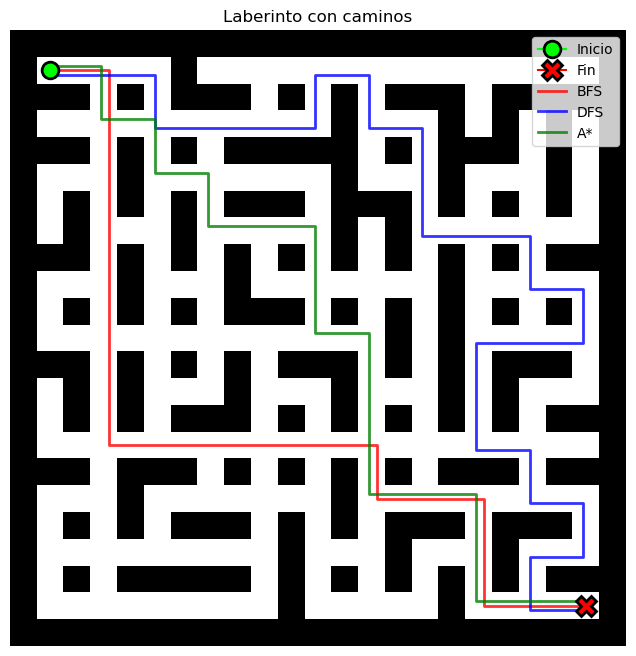

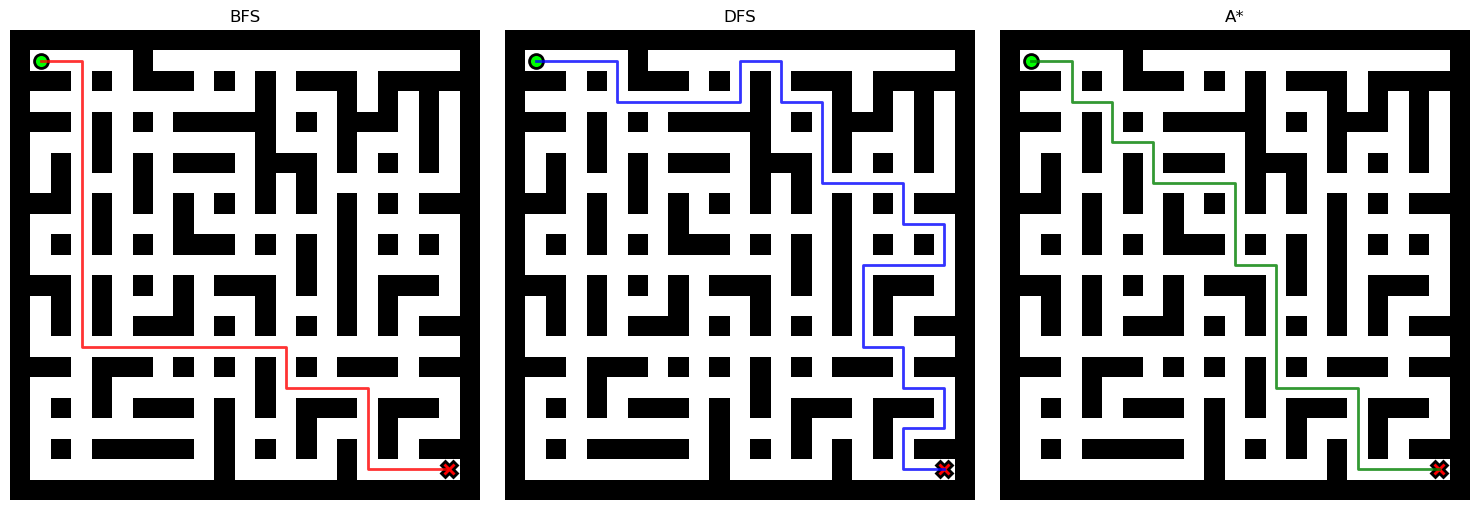

In [191]:
draw_maze(maze, start_state, goal_state, {
    "BFS": result_bfs.getPath(),
    "DFS": result_dfs.getPath(),
    "A*": result_astar.getPath()
})

draw_maze(maze, start_state, goal_state, {
    "BFS": result_bfs.getPath(),
    "DFS": result_dfs.getPath(),
    "A*": result_astar.getPath()
}, separate_plots=True)

### Rendimiento de los caminos

In [192]:


def run_search(strategy, heuristic=None):
    start_node = node(state=start_state)
    search = BlindSearch(start=start_node, successor=successor, goal=goal,
                         strategy=strategy, goal_state=goal_state, heuristic=heuristic)
    t0 = time.time()
    result = search.find()
    t1 = time.time()
    elapsed = t1 - t0
    path = result.getPath()
    return {
        "Estrategia": strategy,
        "Tiempo (s)": round(elapsed, 6),
        "Nodos expandidos": len(search.visited),
        "Longitud del camino": len(path)
    }

results = []
results.append(run_search("bfs"))
results.append(run_search("dfs"))
results.append(run_search("a*", heuristic=heuristic))

df_results = pd.DataFrame(results)
df_results


finished in 281 iterations
finished in 77 iterations
finished in 166 iterations


,Estrategia,Tiempo (s),Nodos expandidos,Longitud del camino
0,bfs,0.004911,281,41
1,dfs,0.001209,96,57
2,a*,0.002110,196,41


# Conclusiones

## Algoritmos de Búsqueda
- **BFS (Breadth-First Search)**: Garantiza encontrar el camino óptimo (menor número de pasos) pero explora muchos nodos innecesarios.
- **DFS (Depth-First Search)**: No garantiza optimalidad y puede encontrar caminos muy largos, especialmente en laberintos con múltiples rutas.
- **A\* (A-star)**: Es capaz de encontrar un camino óptimo o casi óptimo tal como BFS pero explora menos nodos gracias a la heurística Manhattan.

## Heurística Manhattan
- La distancia Manhattan es ideal para laberintos de cuadrícula porque refleja exactamente los movimientos posibles (arriba, abajo, izquierda, derecha).
- Es **admisible** porque nunca sobreestima el costo real - la distancia real siempre será mayor o igual a la distancia Manhattan.
- Permite que A* sea tanto **óptimo** como **eficiente**.

## Generación de Laberintos
- **MST puro**: Crea laberintos con exactamente un camino entre cualquier par de puntos.
- **MST + aristas adicionales**: Permite crear laberintos con múltiples caminos, ideales para comparar algoritmos de búsqueda.
- El parámetro `extra_paths_ratio` controla la complejidad: 0.0 = un solo camino, 0.3 = muchos caminos alternativos.
- Aunque si generamos más caminos estos no son tan atractivos visualmente, con coeficientes altos se termina más bien creando muchos ciclos pequeños sin caminos alternativos largos.

## Ventajas de Múltiples Caminos
- Permite evaluar la **eficiencia** real de cada algoritmo de búsqueda.
- A* demuestra su superioridad al encontrar caminos óptimos con menos exploración.
- Los laberintos se vuelven más realistas y desafiantes para los algoritmos.